In [44]:
import networkx as nx
import math
import numpy as np
#https://networkx.org/documentation/stable/tutorial.html

In [46]:
def init_ring(n):
    """Initializes a graph in ring structure with n nodes"""
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n-1):
        G.add_edge(i,i+1)
    pos = nx.circular_layout(G)
    G.add_edge(0,n-1)
    nx.draw(G, pos=pos)
    print(list(G.nodes))
    return(G)

def mySolve(G):
    n = len(G.nodes)
    k = math.log(n,10)
    for i in range(n):
        distances = nx.floyd_warshall(G, weight='weight')
        farthest_node = int(max(distances[i], key=distances[i].get))
        if farthest_node > k:
            G.add_edge(i,farthest_node)
    pos = nx.circular_layout(G)
    nx.draw(G,pos=pos)
    return(G)
    #subG = G.subgraph(range(v,farthest_node+1))

In [52]:
# Demand matrix
def init_demand_matrix(G):
    """Returns a demand matrix, where each peer pair has the same demand in %"""
    nodesList = G.nodes
    demandMatrix = np.full((len(nodesList),len(nodesList)),1/len(nodesList)**2)
    return demandMatrix

In [357]:
# Binary Tranformations and Operations
def intToBin(x,graphSize):
    """Transforms a nodes integer representation to str(binary) representation"""
    decimalSize = math.ceil(math.log(graphSize,2))
    temp = bin(x)
    binary = "0"*(decimalSize-len(temp)+2) +temp[2::]
    return binary 

def binToInt(x,graphSize):
    """Transforms a nodes str(binary) representation to integer representation"""
    decimalSize = math.ceil(math.log(graphSize,2))
    integer = 0
    for i in range(decimalSize-1,0,-1):
        integer += int(x[i]) * 2**i
    return integer


In [412]:
# demand-aware binary search
def construct_binary_search(G):
    for i in range(len(G.nodes)):
        binaryGUID = intToBin(i,len(G.nodes))
        for j in range(len(binaryGUID)):
            peer = (i + 2**j) % len(G.nodes)
            G.add_edge(i,peer)
    return G


def construct_demand_aware_binary_search(G,demandMatrix):
    """Constructs edges in a ring graph, to enable demand aware binary search"""
    copyDemandMatrix = demandMatrix
    maxEdge = np.argmax(copyDemandMatrix)
    row = maxEdge % len(copyDemandMatrix)
    col = maxEdge - len(copyDemandMatrix)*row
    
    # If demand the same for all, do binary search
    if copyDemandMatrix[row][col] == 1/(len(copyDemandMatrix)**2):
        construct_binary_search(G)
        return G
    
    
    
    return G

# Testing

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


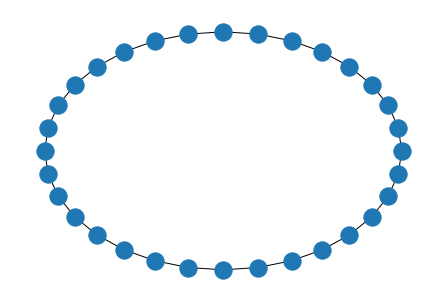

In [419]:
# Init size for Ring, 2^k
k = 5
G = init_ring(2**k)
demandMatrix = init_demand_matrix(G)

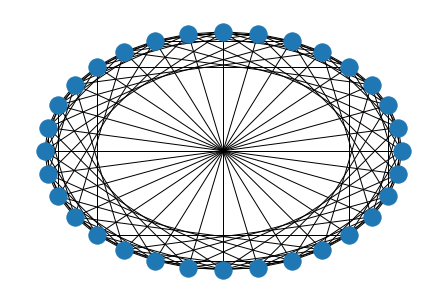

In [420]:
G = construct_demand_aware_binary_search(G,demandMatrix)
pos = nx.circular_layout(G)
nx.draw(G,pos=pos)

In [103]:
demandMatrix[0][1] = 1
print(construct_binary_search(G))
print(~-1)

0b10
['0', 'b', '1', 1]


ValueError: invalid literal for int() with base 10: "['0', 'b', '1', 1]"

In [43]:
#Testing
print(G.number_of_edges(),2**(k+1))

#Test if every node can reach every other in max. log(n) hops
distances = nx.floyd_warshall(G, weight='weight')
for i in range(2**k):
    maxKey = max(distances[i], key=distances[i].get)
    tempMax = distances[i][maxKey]
print(k >= tempMax,tempMax)


16 32
False 8.0


# Proof

In [61]:
def init_matrix(k):
    n = 2**k
    matr_graph = []
    
    temp = []
    temp.append(bin(1),bin(n))
    temp.append(['0b' + ''])
    matr_graph.append((bin(0),[bin(1),bin(n)]))
    
    
    for i in range(1,n-1):
        temp = []
        temp.append(bin(i))
        temp.append(bin(i-1))
        temp.append(bin(i+1))
        matr_graph.append((temp[0],temp[1:]))
    print(matr_graph)

In [62]:
init_matrix(3)

[('0b1', ['0b10', '0b0']), ('0b10', ['0b11', '0b1']), ('0b11', ['0b100', '0b10']), ('0b100', ['0b101', '0b11']), ('0b101', ['0b110', '0b100']), ('0b110', ['0b111', '0b101'])]


In [65]:
bin(7)

'0b111'